# Boys and girls

+ 1 Introduction 介绍
+ 2 Load and check data 加载并检查数据
    + 2.1 load data 加载数据
    + 2.2 Outlier detection 异常值检测
    + 2.3 joining train and test set 拼接训练集和测试集
    + 2.4 check for null and missing values 检查缺失值
+ 3 Feature analysis 特征分析
    + 3.1 Numerical values 数值特征
    + 3.2 Categorical values 类别特征
+ 4 Filling missing Values 填补缺失数据
    + 4.1 Age 年龄
+ 5 Feature engineering 特征工程
    + 5.1 Name/Title 名字/职称
    + 5.2 Family Size 家庭大小
    + 5.3 Cabin 船舱
    + 5.4 Ticket 票
+ 6 Modeling 建模
    + 6.1 Simple modeling 简单模型
        + 6.1.1 Cross validate models 交叉验证模型
        + 6.1.2 Hyperparamater tunning for best models 微调超参数
        + 6.1.3 Plot learning curves 绘制学习曲线
        + 6.1.4 Feature importance of the tree based classifiers 特征重要性
    + 6.2 Ensemble modeling 模型融合
        + 6.2.1 Combining models 融合模型
    + 6.3 Prediction 预测
        + 6.3.1 Predict and Submit results 预测并提交结果
        
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

https://www.kaggle.com/headsortails/pytanic

## 1. 介绍
男孩还是女孩是一个二分类问题，类别均衡，比赛地址为https://www.kaggle.com/c/girls-and-boys

## 2. 加载并检查数据
### 2.1 加载数据

In [99]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv',header=None)
test = pd.read_csv('test.csv',header=None)
target = train[249]
#248列是迷惑特征，有数据泄露
train = train.drop([248],axis=1)
test = test.drop([248],axis=1)

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,249,250
0,1.280000e+11,983.0,1080.0,1190.0,1200.0,586.18422,849.72675,1006.80617,1174.74439,1174.74439,...,0.0,0.0,0.0,0.0,0.0,0.0,DP0-L-3,36,-1,NaN
1,1.280000e+11,826.0,1060.0,1160.0,1120.0,400.33860,825.47838,1048.93397,1079.99396,1079.99396,...,0.0,0.0,0.0,0.0,0.0,0.0,IW9-I-3,56,1,NaN
2,1.280000e+11,1040.0,1170.0,1250.0,1180.0,125.85468,385.36105,947.27780,1182.54942,1182.54942,...,0.0,0.0,0.0,0.0,0.0,0.0,AP0-I-3,56,1,NaN
3,1.280000e+11,1100.0,1140.0,1240.0,1180.0,825.63722,881.96425,1086.06402,1186.67985,1186.67985,...,0.0,0.0,0.0,0.0,0.0,0.0,AN0-L-2,37,1,NaN
4,1.280000e+11,910.0,1150.0,1250.0,1220.0,551.03916,730.62394,984.53070,1200.22696,1200.22696,...,0.0,0.0,0.0,0.0,0.0,0.0,IR4-L-2,36,1,NaN


### 2.2 异常值检测

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
 


In [5]:
def sort_categorical_feature(df):
    categorical_feature=[]
    numerical_feature=[]
    col_type = df.dtypes
   
    for k in list(col_type.index):
        if col_type[k]== np.object:
            categorical_feature.append(k)
        else:
            numerical_feature.append(k)
        
        
    return categorical_feature,numerical_feature
        


In [6]:
[categorical_feature,numerical_feature] = sort_categorical_feature(train)
numerical_feature
Outliers_to_drop = detect_outliers(train,10,numerical_feature)
train.loc[Outliers_to_drop] # Show the outliers rows

C:\Users\MappingLab-lxy\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,249,250
4765,1.290000e+11,1090.0,963.0,1080.0,1120.0,500.61608,674.03676,908.541330,1096.87741,1096.87741,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,75,-1,NaN
4923,1.290000e+11,1010.0,935.0,1030.0,1100.0,370.61144,659.98471,995.335220,1096.74256,1096.74256,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,75,1,NaN
5555,1.290000e+11,1040.0,934.0,1100.0,1140.0,368.79576,572.02387,896.826160,1071.07483,1071.07483,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,51,1,NaN
6100,1.290000e+11,1050.0,939.0,1100.0,1140.0,298.48614,481.23560,849.981710,1068.54298,1068.54298,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,51,-1,NaN
6800,1.290000e+11,1070.0,939.0,1080.0,1130.0,409.45400,658.97779,912.854270,1082.52340,1082.52340,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,51,1,NaN
7209,1.290000e+11,1040.0,921.0,1090.0,1100.0,470.76680,661.51446,962.750620,1097.15678,1097.15678,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,75,-1,NaN
7877,1.290000e+11,1100.0,939.0,1060.0,1130.0,502.80398,696.55985,911.460230,1070.08920,1070.08920,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,51,1,NaN
8055,1.290000e+11,1070.0,938.0,1070.0,1110.0,385.71602,723.35348,897.362260,1105.02953,1105.02953,...,0.0,0.0,0.0,0.0,0.0,0.0,IW9-S-3,50,-1,NaN
8859,1.290000e+11,1030.0,957.0,1120.0,1120.0,653.65778,784.48732,987.569110,1102.91996,1102.91996,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,51,1,NaN
9026,1.290000e+11,943.0,931.0,1070.0,1090.0,651.86726,731.14079,1006.885160,1100.26851,1100.26851,...,0.0,0.0,0.0,0.0,0.0,0.0,IH2-Q-3,75,1,NaN


In [7]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 连接训练集和测试集

In [100]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
## 对训练数据和测试数据进行一致的特征处理
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 检测缺失值

In [101]:
missing_data = dataset.isnull().sum()
missing_data =missing_data[missing_data!=0]
missing_data.sort_values(ascending=False)[:20]
# plt.figure(figsize=(15,20))
# g = sns.barplot(y=list(missing_data.index),x=list(missing_data.values),orient='h')
# g.set_xlabel("Missing Data",fontsize=12)
# g.set_ylabel("Features",fontsize=12)
# g.tick_params(labelsize=9)
# g.set_title("Missing Data")

250    93933
73     93933
43     93933
44     93933
29     93933
74     93933
30     93933
72     93933
71     93933
70     93933
69     93933
64     92984
63     92984
66     92984
68     92984
42     92984
41     92984
65     92984
67     92984
149    43937
dtype: int64

In [102]:
train.info()
train.isnull().sum().sort_values(ascending=False)[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74707 entries, 0 to 74706
Columns: 250 entries, 0 to 250
dtypes: float64(174), int64(49), object(27)
memory usage: 142.5+ MB


250    74707
29     74707
30     74707
74     74707
73     74707
43     74707
44     74707
72     74707
71     74707
70     74707
dtype: int64

In [103]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,247,249,250
count,7.470700e+04,74634.000000,74707.000000,74618.000000,74614.000000,74707.000000,74707.000000,74696.000000,74697.000000,74697.000000,...,74693.0,74693.0,74693.0,74693.0,74693.0,74693.0,74693.0,74707.000000,74707.000000,0.0
mean,1.283081e+11,1070.068829,1103.325391,1184.055429,1183.007210,414.559725,645.765624,960.414721,1145.824279,1145.824279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.240566,-0.066379,NaN
std,4.617155e+08,127.390698,52.789166,49.661377,38.032623,264.808588,164.100543,84.438072,32.182527,32.182527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.902564,0.997801,NaN
min,1.280000e+11,605.000000,857.000000,847.000000,1030.000000,15.431800,43.789800,43.789800,43.789800,43.789800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.000000,-1.000000,NaN
25%,1.280000e+11,1050.000000,1070.000000,1150.000000,1160.000000,160.442010,510.610635,899.120845,1126.795550,1126.795550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.000000,-1.000000,NaN
50%,1.280000e+11,1120.000000,1110.000000,1190.000000,1190.000000,421.741840,652.668000,963.880365,1149.436280,1149.436280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.000000,-1.000000,NaN
75%,1.290000e+11,1150.000000,1140.000000,1220.000000,1210.000000,636.430300,771.369810,1023.852370,1167.328030,1167.328030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.000000,1.000000,NaN
max,1.290000e+11,1350.000000,1290.000000,1330.000000,1310.000000,1023.508080,1126.293640,1242.962680,1255.543427,1255.543427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.000000,1.000000,NaN


## 3. 特征分析
### 3.1 数值型特征

#### 相关性

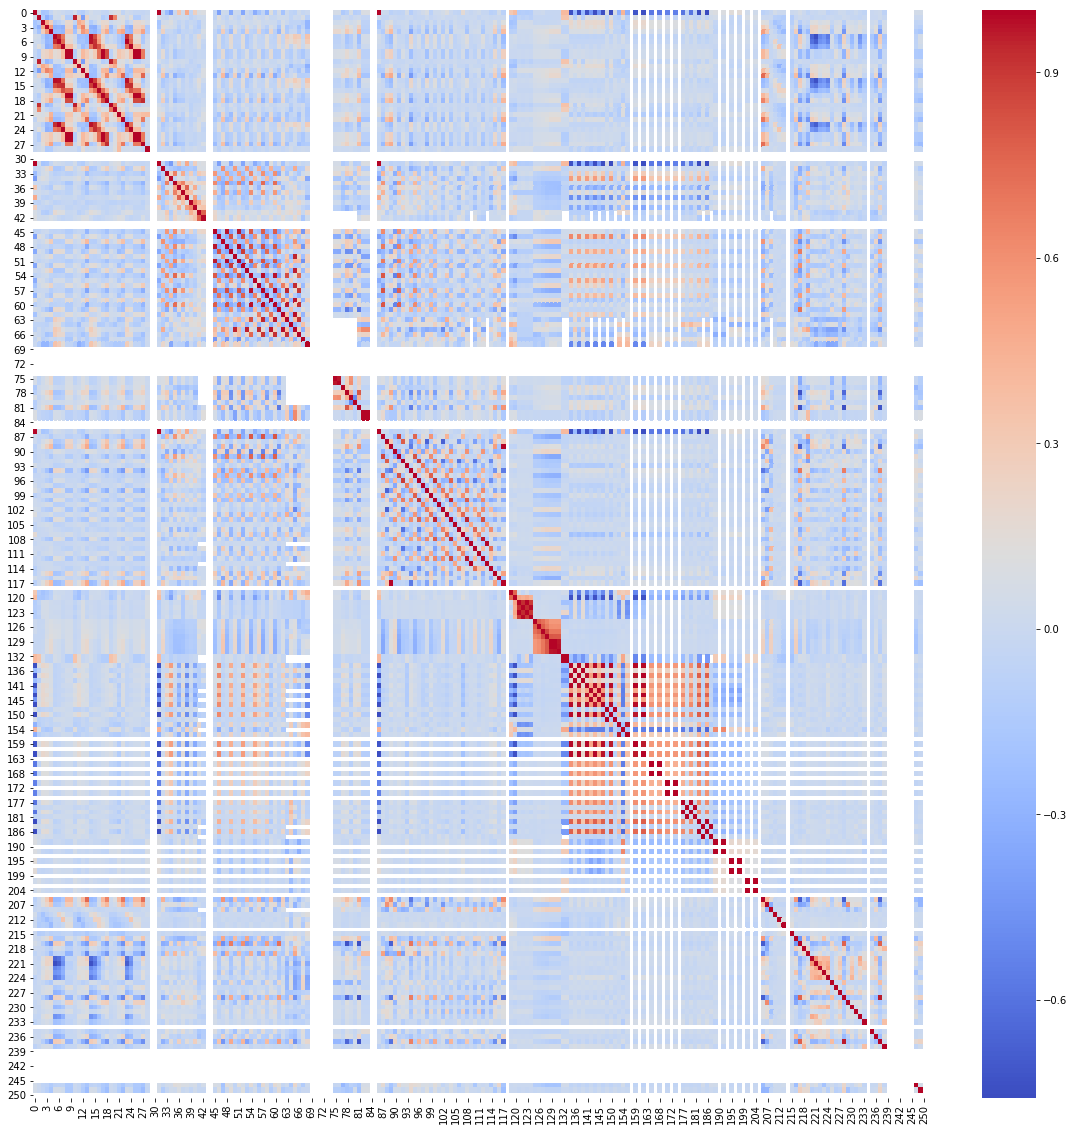

In [12]:
train_corr = train[numerical_feature].corr()
plt.figure(figsize=(20,20))
g = sns.heatmap(train_corr,annot=False, fmt = ".2f", cmap = "coolwarm")

In [67]:
most_corr = abs(train_corr[249]).sort_values(ascending=False)[:20]

In [68]:
boys = train[train[249]==1]
girls = train[train[249]==-1]
boys_col = "blue"
girls_col = "red"

#### 高相关特征的分布

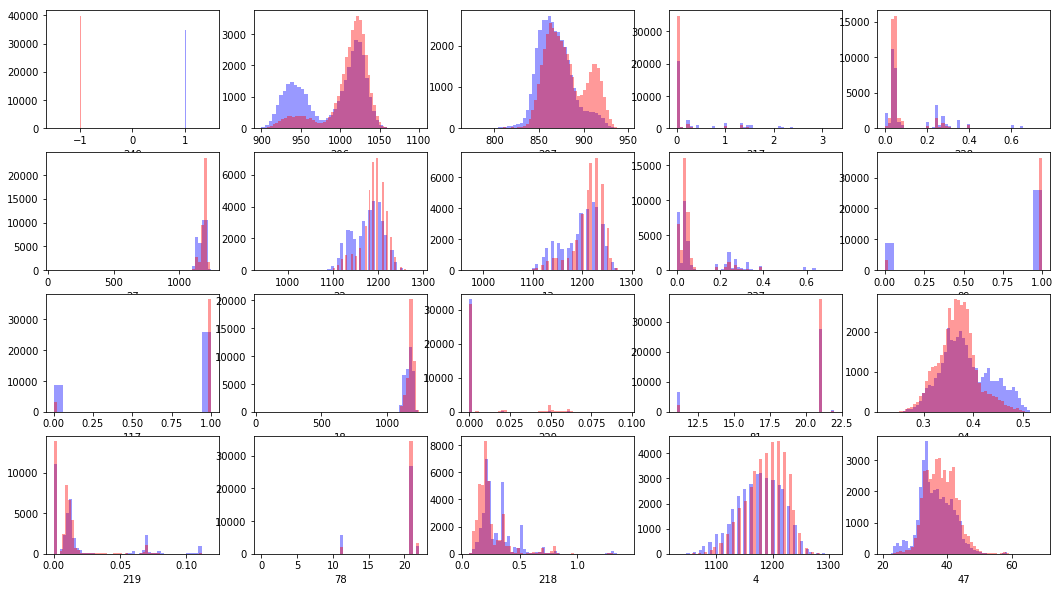

In [75]:

plt.figure(figsize=[18,10])
i=1
for k in list(most_corr.index):
    plt.subplot(4,5,i)
    sns.distplot(boys[k].dropna().values,  kde=False, color=boys_col)
    sns.distplot(girls[k].dropna().values,  kde=False, color=girls_col,
            axlabel=k)
    i+=1


#### 斜度/峰度

In [25]:
#斜度
dataskew = dataset.skew()

In [26]:
#峰度
datakurt = dataset.kurt()

## 4. 填补缺失值

In [109]:
all_nan_col = dataset[missing_data[(missing_data/dataset.shape[0])==1].index]
dataset =dataset.drop(all_nan_col.columns,axis=1)

In [142]:
missing_data_rate=(missing_data[missing_data!=93933]/dataset.shape[0]).sort_values(ascending=False)
missing_data_rate[:25]

68     0.989897
67     0.989897
66     0.989897
65     0.989897
41     0.989897
42     0.989897
64     0.989897
63     0.989897
158    0.467748
161    0.467748
132    0.467748
155    0.467748
133    0.467748
149    0.467748
146    0.467748
143    0.467748
140    0.467748
137    0.467748
152    0.467748
134    0.467748
249    0.204678
157    0.048311
135    0.048311
136    0.048311
138    0.048311
dtype: float64

In [137]:
train_corr[249][missing_data_rate[missing_data_rate>0.1].index]

68    -0.006857
67    -0.005773
66    -0.058788
65     0.070528
41    -0.021431
42    -0.022369
64    -0.070142
63    -0.071314
158         NaN
161         NaN
132    0.001862
155         NaN
133    0.001862
149         NaN
146         NaN
143         NaN
140         NaN
137         NaN
152         NaN
134         NaN
249    1.000000
Name: 249, dtype: float64

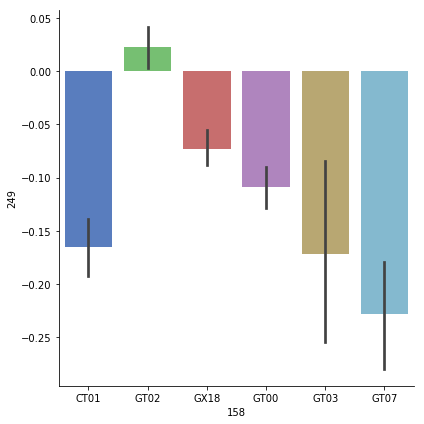

In [148]:
# 68 67 132 133
g = sns.factorplot(x=158,y=249,data=train,kind="bar", size = 6 , 
palette = "muted")

In [152]:
col_158 = train[158]
target[col_158[col_158.isnull()].index]

1        1
4        1
6        1
8        1
9       -1
13       1
18       1
20      -1
22       1
24      -1
25       1
29       1
31      -1
33       1
35      -1
39       1
40      -1
41      -1
42       1
43       1
44      -1
45      -1
47       1
50       1
51      -1
52       1
56       1
61      -1
63      -1
68       1
        ..
74644    1
74645   -1
74647    1
74650   -1
74651    1
74652    1
74654   -1
74655    1
74657    1
74658    1
74659   -1
74662   -1
74664   -1
74666    1
74668   -1
74674   -1
74677   -1
74678   -1
74679    1
74681   -1
74683    1
74685    1
74686    1
74688    1
74689    1
74690    1
74692   -1
74699   -1
74701   -1
74704    1
Name: 249, Length: 34927, dtype: int64

In [14]:
xg_train_label = data[249]
xg_train_data = dropstrdata[:trainsize]
xg_test_data = dropstrdata[trainsize:]
xg_train_data.shape

(76900, 201)

In [15]:
xg_test_data.shape

(19226, 201)

In [94]:
train_num = np.int64(trainsize*0.85)

In [95]:
trainsize

76900

In [96]:
train_data_arr = xg_train_data[:train_num]
train_label_arr = xg_train_label[:train_num]
test_data_arr = xg_train_data[train_num:]
test_label_arr = xg_train_label[train_num:]


In [97]:
xg_test_data.shape

(19226, 201)

In [110]:
cl = xg.XGBClassifier(learning_rate=0.12,max_depth=4,subsample=0.9,silent=0,gamma=0,n_estimators=1000)

In [111]:
cl.fit(X=train_data_arr,y=train_label_arr)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.12, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=0.9)

In [112]:
cl.score(test_data_arr,test_label_arr)

0.74390983961855228

In [25]:
cl.feature_importances_[:5]

array([ 0.01578192,  0.00286944,  0.        ,  0.        ,  0.00286944], dtype=float32)

In [113]:
pred_label = cl.predict(xg_test_data)

In [114]:
pred_label

array([ 1, -1, -1, ...,  1,  1, -1], dtype=int64)

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [231]:
X_train = train_data_arr
Y_train = train_label_arr
X_test = test_data_arr
Y_test = test_label_arr
X_pred = xg_test_data

In [232]:
logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

logreg.score(X_train, Y_train)

0.524187256176853

In [233]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_pred)

random_forest.score(X_train, Y_train)

1.0

In [247]:
feature_importances= pd.Series(random_forest.feature_importances_)
feature_importances.sort_values(ascending=False)

172    0.023478
171    0.022726
163    0.016548
27     0.015267
162    0.014591
182    0.014080
170    0.013593
18     0.013265
42     0.011260
45     0.011069
48     0.010873
191    0.010809
54     0.010405
200    0.010309
69     0.010065
76     0.009988
94     0.009854
22     0.009825
51     0.009552
41     0.009103
30     0.008808
35     0.008797
74     0.008698
72     0.008693
73     0.008529
44     0.008494
56     0.008443
39     0.008393
40     0.008386
33     0.008369
         ...   
131    0.000157
64     0.000154
129    0.000152
91     0.000103
57     0.000077
95     0.000073
149    0.000056
147    0.000045
195    0.000000
194    0.000000
197    0.000000
188    0.000000
198    0.000000
196    0.000000
193    0.000000
135    0.000000
168    0.000000
161    0.000000
159    0.000000
157    0.000000
155    0.000000
153    0.000000
151    0.000000
141    0.000000
139    0.000000
137    0.000000
199    0.000000
67     0.000000
66     0.000000
100    0.000000
Length: 201, dtype: floa

In [250]:
Y_pred

array([ 1,  1, -1, ...,  1,  1, -1], dtype=int64)

In [115]:
submission = pd.DataFrame({
        "Id": test.index+1,
        "label": pred_label
    })
submission.to_csv('submit.csv', index=False)